<a href="https://colab.research.google.com/github/huanfachen/DSSS/blob/main/Week_6/Practical_06_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="float:left">
    <h1 style="width:600px">CASA0006 Practical 6: Deep learning applications</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

## Introduction
In this practical, we will use TensorFlow and [YOLOv5] to:

1. Build a convolutional neural network (CNN) for written digit identification;
2. Conduct object detection in satellite imagery, using pre-trained deep learning models YOLOv5.

## Setting up Google Colab

As installing and configuring tensorflow and YOLO on local machines can be a pain, we recommend using Google Colab for this practical. Click [here](https://colab.research.google.com/github/huanfachen/DSSS/blob/main/Week_6/Practical_06_SOLUTION.ipynb) to run this practical on Google Colab, which requires a Google account.

Resource limit of Google Colab under free plan:

- Memory: up to 12 GB.
- Maximum duration of running a notebook: notebooks can run for at most **12 hours**, depending on availability and your usage patterns. (The notebook will die after at most 12 hours)
- GPU duration: dynamic, up to a few hours. If you use GPU regularly, runtime durations will become shorter and shorter and disconnections more frequent.

*Very Important* - we will use the GPU on Google Colab to accelerate the model training. To do this, go to 'Runtime' -> 'Change runtime type' -> Select 'T4 GPU' -> Save. See below.

![](https://github.com/huanfachen/DSSS/blob/main/Figures/Colab_GPU_setting.jpg?raw=true)

If you are following along in your own development environment, rather than Colab, see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment.

## CNN Overview

![CNN](https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/cnn.png)

Convolutional neural networks (CNN) is a special type of neural network for image or image-like features. 

CNN is a complex subject and we could do a 10-week module on it. Here, we aim to cover the basics of CNN with loads of illustrations and examples.

In [ ]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output reproducible across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# # Where to save the figures
# try:
#     import subprocess
#     subprocess.run("git config --get remote.origin.url | grep 'astro-informatics'", shell=True, check=True)
#     PROJECT_ROOT_DIR = "."
#     CHAPTER_ID = "Lecture19_Images"
# except: 
#     PROJECT_ROOT_DIR = "."
#     CHAPTER_ID = ""

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def crop(images):
    return images[150:220, 130:250]
    
import warnings
warnings.filterwarnings('ignore')

## Convolutional Layers in NN 

* Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s.
* Used in image recognition also in voice recognition and natural language processing 
* Local Field of View
* Used to define local features in an image - data compression

<img src="https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/localFov.jpeg" alt="Drawing" style="width: 500px;"/>

### Why CNN?

* A way of encoding images using a small(er) number of features upon which training (e.g. for classifying images) can take place. 
* Differences in images that enable humans to classify are hypothesise to be extracted in similar ways.

## Convolutional Layers 

* Encode convolutions as a NN 

* Neurons connected to _receptor_ field in next layer that is _smaller_. Uses zero padding to force layers to have same height & width.

* Also can connect large input layer to much smaller layer by spacing out receptor fields (distance between receptor fields is called the _stride_)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/CC.jpeg" alt="Drawing" style="width: 700px;"/>

### Feature Maps 

* Neuron weights can look like small images (w/ size = receptor field)
* Examples below: 1) vertical filter (single vertical bar, mid-image, all other cells zero) 2) horizontal filter (single horizontal bar, mid-image, all other cells zero)
* Both return _feature maps_ (highlights areas of image most similar to filter)


<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/featuremap.jpeg" alt="Drawing" style="width: 800px;"/>

### Stacking Feature Maps 

* More realistic to have several features of similar size i.e. 3D layers 
* A convolutional layer can thereby apply multiple filters to its input and be capable of detecting multiple features 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/stacked.jpeg" alt="Drawing" style="width: 400px;"/>


### Example 

* The following code loads two sample images, using Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chinese temple, and the other of a flower)
* Then it creates two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle), and applies them to both images using a convolutional layer built using TensorFlow’s ${\tt tf.nn.conv2d()}$ function (with zero padding and a stride of 2). 
* Finally, it plots one of the resulting feature maps



In [ ]:
#simple example 
from sklearn.datasets import load_sample_image #load images

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters that are 7x7xchannelsx2 arrays
filters = np.zeros(shape=(7, 7, channels, 2),  dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [ ]:
# Conv2D arguments:
# filters = 4D tensor
# strides = 1D array (1, vstride, hstride, 1)
# padding = VALID = no zero padding, may ignore edge rows/cols
# padding = SAME  = zero padding used if needed
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

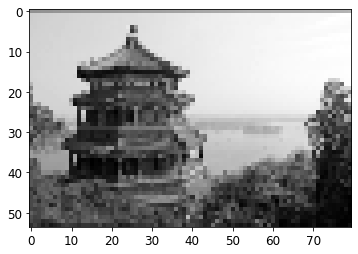

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=8, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map

plt.show()

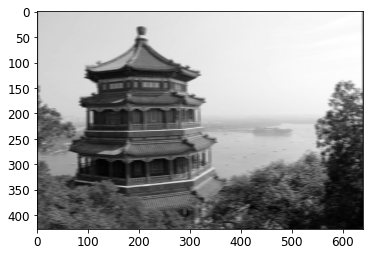

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map

plt.show()

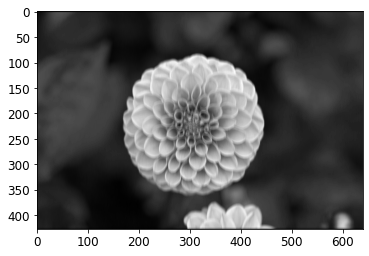

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[1, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map

plt.show()

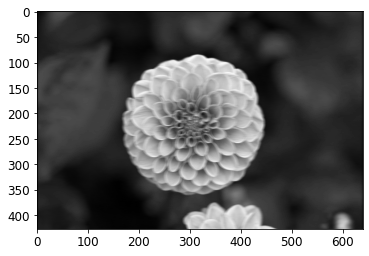

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[1, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map

plt.show()

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/dotproduct-slides.png" alt="Drawing" style="width: 900px;"/>

Note the relation to the dot product 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/example-slides.png" alt="Drawing" style="width: 900px;"/>



<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/6filter-slides.png" alt="Drawing" style="width: 900px;"/>

The convolution layer comprises of a set of independent filters (6 in the example shown). Each filter is independently convolved with the image and we end up with 6 feature maps of shape 28x28x1.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/simpleseries-slides.png" alt="Drawing" style="width: 900px;"/>

All these filters are initialized randomly and become our parameters which will be learned by the network subsequently.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/padding.jpeg" alt="Drawing" style="width: 900px;"/>



## Pooling Layers 

* Pooling layers aim to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). Pooling layer operates on each feature map independently.

* Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. 

* However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean.

<img src="https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/pool.jpeg" alt="Drawing" style="width: 900px;"/>

<img src="https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/maxpool-slides.png" alt="Drawing" style="width: 900px;"/>



## CNN Architectures 

* Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer; max(0,x), then a pooling layer, then another few convolutional layers (+ ReLU), then another pooling layer, and so on.

* The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps) thanks to the convolutional layers

* At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers, and the final layer outputs the prediction 

* There are many successful and popular CNN structures, including LeNet, AlexNet, ResNet.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/aCNN.jpeg" alt="Drawing" style="width: 1000px;"/>

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/excnn.jpeg" alt="Drawing" style="width: 1500px;"/>



### LeNet

LeNet is a series of CNN structure proposed by LeCun et al., and have been widely used for mnist. The first LeNet, LeNet-1, was trained in 1989.  

<img src="https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/lenet.jpeg" alt="Drawing" style="width: 500px;"/>



### AlexNet

AlexNet is another CNN structure, designed by *Alex Krizhevsky* in collaboration with *Ilya Sutskever* and *Geoffrey Hinton*. 

AlexNet was submitted in ImageNet Challenge [http://www.image-net.org/challenges/LSVRC/](http://www.image-net.org/challenges/LSVRC/). It won the champion and achived a top-5 error of 15.3%, much better than the runner-up.

<img src="https://raw.githubusercontent.com/huanfachen/DSSS/main/Figures/alexnet.jpeg" alt="Drawing" style="width: 500px;"/>



## ResNet-34

Residual neural network (also referred to as a residual network or ResNet) is a CNN architecture in which the layers learn residual functions with reference to the layer inputs and some connections skip two or more layers. 

It was first proposed by [Kaiming He](https://people.csail.mit.edu/kaiming/), see [this ground-breaking paper](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html), with 260766	citations on Google Scholar.

It was developed in 2015 for image recognition, and won the ImageNet Large Scale Visual Recognition Challenge of that year.

The residual connection stablises teh training and convergence of CNN with hundreds of layers, and has become a common motif in later CNNs, such as BERT and GPT models.

ResNet-34 is one type of ResNet and has 34 convolutional layers. It is pretrained on the ImageNet dataset.

In [ ]:
from functools import partial  
# What is partial? See https://chriskiehl.com/article/Cleaner-coding-through-partially-applied-functions

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

We will use this ResNet-34 to tackle the MNIST task.

In [ ]:
# import MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

_**Beware, the cell below will take a long time to run!**_

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 484s 281ms/step - loss: 1.0357 - accuracy: 0.6352 - val_loss: 0.3549 - val_accuracy: 0.8752
Epoch 2/5
1719/1719 [==============================] - 476s 277ms/step - loss: 0.4430 - accuracy: 0.8537 - val_loss: 0.3218 - val_accuracy: 0.8832
Epoch 3/5
1719/1719 [==============================] - 475s 276ms/step - loss: 0.3656 - accuracy: 0.8759 - val_loss: 0.3184 - val_accuracy: 0.8840
Epoch 4/5
1719/1719 [==============================] - 474s 276ms/step - loss: 0.3160 - accuracy: 0.8935 - val_loss: 0.2975 - val_accuracy: 0.8870
Epoch 5/5
1719/1719 [==============================] - 474s 276ms/step - loss: 0.3040 - accuracy: 0.8960 - val_loss: 0.2773 - val_accuracy: 0.8988


In [ ]:
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

313/313 [==============================] - 17s 54ms/step - loss: 0.2911 - accuracy: 0.8965


## YOLOv5 for Object Detection in Satellite Imagery

Having explored CNN and ResNet, we are now ready to apply this to a more explicitly spatial use case: object detection in satellite imagery.

Read the [following guide](https://bellingcat.github.io/RS4OSINT/C5_Object_Detection.html), and then complete the rest of this workbook.

## What is YOLOv5
Object detection is a fairly complicated task, and there are a number of different approaches to it. In this tutorial, we’ll be using a model called YOLOv5. YOLO stands for **You Only Look Once**, and it’s a model that was developed by [Joseph Redmon et al.](https://pjreddie.com/), and the full paper detailing the model can be found [here](https://arxiv.org/abs/1506.02640).

The YOLOv5 model is a convolutional neural network (CNN), which is a type of deep learning model. CNNs are very good at identifying patterns in images, particularly in small regions of images. This is important for object detection, because we want to be able to identify objects even if they’re partially obscured by other objects.

YOLO works by chopping an image up into a grid, and then predicting the location and size of objects in each grid cell:

![](https://bellingcat.github.io/RS4OSINT/images/yolo.jpg)

It learns the locations of these objects by training on a dataset of images in which each object is indicated by a bounding box. Then, when it’s shown a new image, it will attempt to predict bounding boxes around the objects in that image. The standard YOLO model is trained on the COCO dataset, which contains over 200,000 images of 80 different objects ranging from people to cars to dogs. YOLO models pre-trained on this dataset work great out of the box to detect objects in videos, photographs, and live streams. But the nature of the objects we’re interested in is a bit different.

Luckily, we can simply **re-train** the YOLOv5 model on datasets of labeled satellite imagery. We will walk through the process of re-training YOLOv5 on a custom dataset, and then using it to identify objects in satellite imagery pulled from Google Earth Engine or Google Map.

In [14]:
!git clone https://github.com/huanfachen/yolov5_RS  # clone repo
#%cd yolov5_RS
%pip install -qr yolov5_RS/requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5_RS'...
remote: Enumerating objects: 11625, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11625 (delta 0), reused 0 (delta 0), pack-reused 11622
Receiving objects: 100% (11625/11625), 77.52 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (7689/7689), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━

We will use public satellite imagery dataset from Roboflow, specifically, [this link](https://universe.roboflow.com/gdit/aerial-airport/dataset/1).

What is Roboflow? It is a Computer Vision developer framework for better data collection to preprocessing and model training techniques. Roboflow contains public datasets readily available to users and also has access for users to upload their own custom data.

You can explore a gallery of public datasets on [Roboflow Universe](https://universe.roboflow.com/). These datasets are frequently updated.

Note that you need a Roboflow API KEY to access the datasets. To get your own API KEY, visit [this link](https://docs.roboflow.com/api-reference/authentication).

Below is my API KEY in the free tier, which is subject to certain use limit. You can use it for tests, but it might be slow or out of limit. It is always a good idea to get your own API KEY and get control of it.

In [19]:
from roboflow import Roboflow
API_KEY = 'aywzIBJkeuu2TcHztYSq'
rf = Roboflow(api_key=API_KEY)
project = rf.workspace("gdit").project("aerial-airport")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Check the datasets have been downloaded.

In [20]:
!ls
!ls yolov5_RS

Aerial-Airport-1  sample_data  yolov5_RS
Aerial-Airport-1  CONTRIBUTING.md  gatwick.jpg	README.md	  setup.cfg	  val.py
benchmarks.py	  data		   hubconf.py	README.zh-CN.md   train.py	  weights
CITATION.cff	  detect.py	   LICENSE	requirements.txt  tutorial.ipynb
classify	  export.py	   models	segment		  utils


The next step is to copy the data folder *Aerial-Airport-1* into the folder of yolov5_RS, as the YOLOv5 Python codes require the datasets are in the same folder.

In [17]:
!cp -r Aerial-Airport-1 yolov5_RS

In [18]:
!ls
!ls yolov5_RS

Aerial-Airport-1  sample_data  yolov5_RS
Aerial-Airport-1  CONTRIBUTING.md  gatwick.jpg	README.md	  setup.cfg	  val.py
benchmarks.py	  data		   hubconf.py	README.zh-CN.md   train.py	  weights
CITATION.cff	  detect.py	   LICENSE	requirements.txt  tutorial.ipynb
classify	  export.py	   models	segment		  utils


We will train the model via running the *train.py* file.

The settings, including batch size, is important. The general rule is: the larger batch size, the larger memory required. The batch size is set as 16 here after trial and error. If we set **--batch 32**, Colab might run out of memory and force the training to stop (*setting a '^C' in the proccess*). Note that the memory of Google Colab is default at 12 GB of RAM.

Other factors influencing the required memory of YOLO include image size, batch size, and model size.

See [Discussion on Github](https://github.com/ultralytics/yolov5/issues/3847) or [Stackoverflow](https://stackoverflow.com/a/63797661/4667568).

The following model training takes quite a long time, around 3 hours.

In [ ]:
!less yolov5_RS/train.py

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset.
Models and datasets download automatically from the latest YOLOv5 release.

Usage - Single-GPU training:
    $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recomme nded)
    $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

Usage - Multi-GPU DDP training:
    $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yam l --weights yolov5s.pt --img 640 --device 0,1,2,3

Models:     https://github.com/ultralytics/yolov5/tree/master/models
Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
Tutorial:   https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
"""

import argparse
import math
import os
import random
yolov5_RS/train.py# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset.
Models and datasets download automatic

In [21]:
%%time
!python yolov5_RS/train.py --data {dataset.location}/data.yaml --img 320 --batch 16 --cache

2024-02-02 16:22:24.278922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 16:22:24.278987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 16:22:24.280276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 16:22:25.291579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5_RS/yolov5s.pt, cfg=, data=/content/Aerial-Airport-1/data.yaml, hyp=yolov5_RS/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False,

Then, we will apply the YOLOv5 model to detect objects of a remote sensing image from Google Map.

In [22]:
img='gatwick.jpg'
!python yolov5_RS/detect.py --weights yolov5_RS/weights/general.pt --img 2000 --conf 0.4 --source {os.path.join('yolov5_RS',img)} --line-thickness 2 --exist-ok #--hide-labels --exist-ok

detect: weights=['yolov5_RS/weights/general.pt'], source=yolov5_RS/gatwick.jpg, data=yolov5_RS/data/coco128.yaml, imgsz=[2000, 2000], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5_RS/runs/detect, name=exp, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-58-gebeff592 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 232 layers, 7286973 parameters, 0 gradients
WARNING ⚠️ --img-size [2000, 2000] must be multiple of max stride 32, updating to [2016, 2016]
image 1/1 /content/yolov5_RS/gatwick.jpg: 1728x2016 9 small-vehicles, 2 planes, 1 roundabout, 67.7ms
Speed: 3.2ms pre-process, 67.7ms inference, 538.3ms NMS per image at shape (1, 3, 2016, 2016)
Results saved to yolov5_RS/runs/detect/exp


The results of detected objects are saved in the runs/detect/exp folder, as below.

In [23]:
!ls yolov5_RS/runs/detect/exp

gatwick.jpg


In [24]:
img='gatwick.jpg'

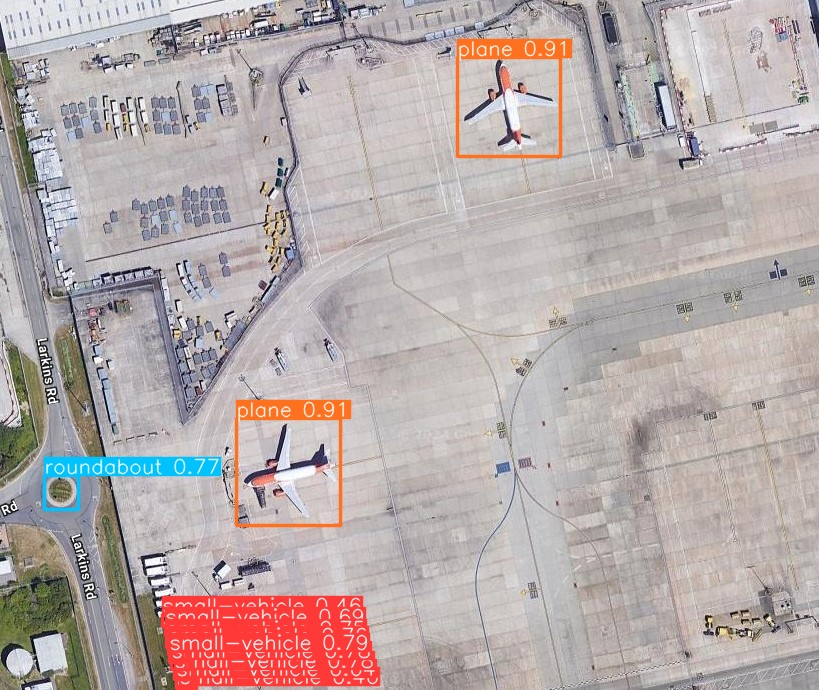

In [25]:
out_dir='yolov5_RS/runs/detect/exp'
Image(filename=os.path.join(out_dir,img))